# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes
from matplotlib import style
from time import sleep
import os
import joblib
import tqdm
style.use("ggplot")
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

#% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Exploratory Analysis Part 1

In this section, we'll explore the data to get well known about how is structured. We gonna start exploring the **portfolio** dataset, then the **profile** dataset and for last the **transcript** dataset. 

### Portfolio Dataset

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


The **id** here need to be changed to **offer_id** for better convenience in preprocessing.

In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [4]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


##### Null values

In [5]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

Dataset has no null values.

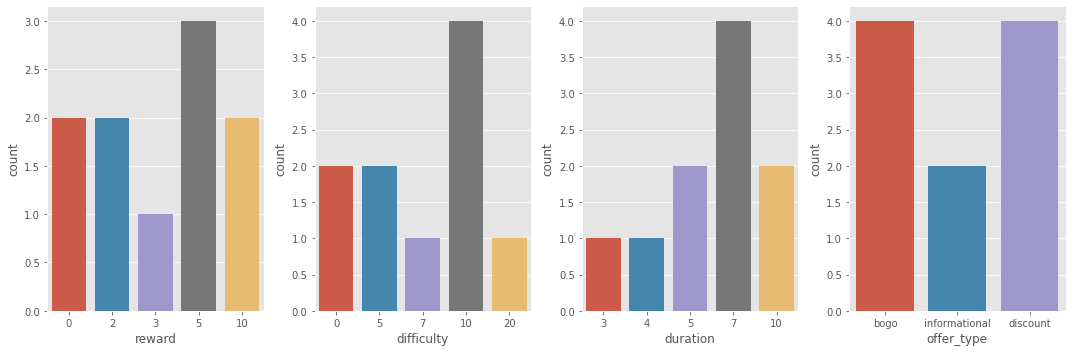

In [6]:
fig, axs = plt.subplots(ncols=4, figsize=(15,5))
sns.countplot(data=portfolio, x='reward', ax=axs[0])
sns.countplot(data=portfolio, x='difficulty', ax=axs[1])
sns.countplot(data=portfolio, x='duration', ax=axs[2])
sns.countplot(data=portfolio, x='offer_type', ax=axs[3])
plt.tight_layout()
plt.savefig('outputs/portfolio_exploration.jpg')

### Profile Dataset

In [7]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


The **id** here need to be changed to **customer_id**  in preprocessing.

In [8]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


We can see that **gender** and **income** has null values, so we need to handle then in the preprocessing step.

In [9]:
profile.gender.value_counts(dropna=False)

M      8484
F      6129
NaN    2175
O       212
Name: gender, dtype: int64

One of things we need to be careful here is duplicates id's

In [10]:
profile.id.nunique() == profile.shape[0]

True

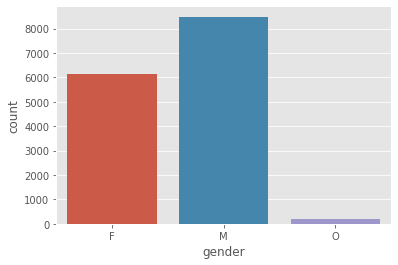

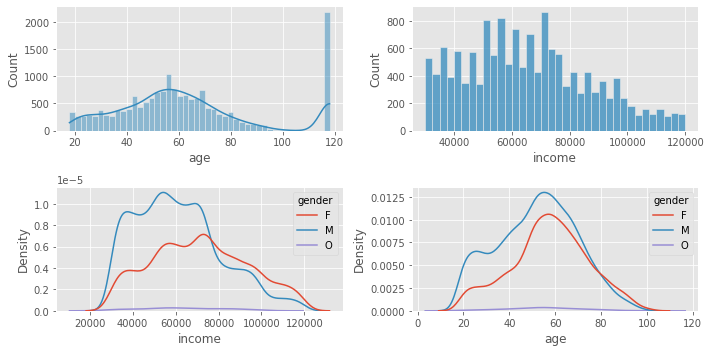

In [11]:
sns.countplot(data=profile, x='gender')
plt.savefig('outputs/profile_gender_exploration.jpg')
fig, axs = plt.subplots(nrows = 2, ncols=2, figsize=(10,5))
sns.histplot(data=profile, x='age', ax=axs[0][0], kde=True)
sns.histplot(data=profile, x='income', ax=axs[0][1])
sns.kdeplot(data=profile, x='income', hue='gender', ax=axs[1][0])
sns.kdeplot(data=profile, x='age', hue='gender', ax=axs[1][1])
plt.tight_layout()
plt.savefig('outputs/profile_exploration.jpg')

We can see that in the **age** variable we have something uncommon, some os the clientes have 100+ years old.

Let's check the 100+ years old clients.

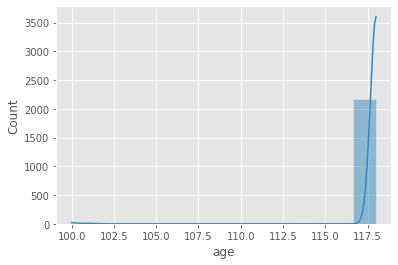

In [12]:
sns.histplot(data=profile[profile.age >= 100], x='age', kde=True);
plt.savefig('outputs/age_over_100.jpg')

Weird, let's check in numbers.

In [13]:
profile[profile.age >= 100].age.value_counts()

118    2175
100      12
101       5
Name: age, dtype: int64

We can see that the majority of the clients with 100+ years old fall into 118 years.

In [14]:
profile[profile.age == 118]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


Apparently **gender** and **income** is all null values for this filter in **age**. We need to handle then in the preprocessing.

### Transcript dataset

In [15]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [16]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [17]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In the **event** column we have 4 categories. In the **value** column we have a dictionary that contains the related transaction based on a certain **event** for a specific client. As shown below

In [18]:
transcript[transcript.person == '68617ca6246f4fbc85e91a2a49552598']

,person,event,value,time
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
38221,68617ca6246f4fbc85e91a2a49552598,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},84
53178,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},168
118294,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},336
130149,68617ca6246f4fbc85e91a2a49552598,offer viewed,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},348
132802,68617ca6246f4fbc85e91a2a49552598,transaction,{'amount': 0.19},354
158119,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},408
177263,68617ca6246f4fbc85e91a2a49552598,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},432
201576,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},504
289715,68617ca6246f4fbc85e91a2a49552598,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},648


We can expect that after the client sees the offer, they gonna convert.

We can do some feature engineering to extract useful features that indicates successfuls offers.

## Preprocessing (Step 1)

In this section, we gonna transform our data into an unique dataframe that contains all the informations int the entities (datasets) given. The best way to do that is to write a function that englobes all the steps we need to do, because imagine that we achieve a successful experiment, this function we'll help us to simplify the testing and deploy process.

### Portfolio Dataset


**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

In [19]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [20]:
def preprocess_portfolio(data):
    """
    """
    # Creating unique columns for each channel.
    channels = ['web', 'email', 'mobile', 'social']
    for channel in channels:
        data['channel_' + channel] = data['channels'].apply(lambda x: 1 if channel in x else 0)
    #data = data.drop(['channels'], axis=1)
    # Creating unique (dummies) columns for each offer_type
    data['offer_type_cat'] = data['offer_type'].values
    data = pd.get_dummies(data, columns=['offer_type'])
    
    # Renaming the id as mentioned before.
    data.rename(columns={'id':'offer_id'}, inplace=True)
    
    return data

In [21]:
portfolio_pp = preprocess_portfolio(portfolio)

In [22]:
portfolio_pp

,reward,channels,difficulty,duration,offer_id,channel_web,channel_email,channel_mobile,channel_social,offer_type_cat,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,bogo,1,0,0
1,10,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo,1,0,0
2,0,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,1,1,1,0,informational,0,0,1
3,5,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,bogo,1,0,0
4,5,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,discount,0,1,0
5,3,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,discount,0,1,0
6,2,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,discount,0,1,0
7,0,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,informational,0,0,1
8,5,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,bogo,1,0,0
9,2,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,discount,0,1,0


### Profile Dataset


**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

In [23]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [24]:
def preprocess_profile(data):
    """
    """
    # Renaming the id columns
    data.rename(columns={'id':'customer_id'}, inplace=True)
    
    # First, let's handle the null values in gender (new category for null values) variable. Then we can create unique columns (dummies) of gender
    data['gender'] = data['gender'].fillna('N')
    data['gender_cat'] = data['gender'].values
    data = pd.get_dummies(data, columns=['gender'])
    
    # For the age 118 problem.
    data['age'] = data['age'].apply(lambda x: np.nan if x ==118 else x)
    
    # Since we have the variable became_member_on, we can create a variable that defines the membership age.
    data['became_member_on'] = pd.to_datetime(data['became_member_on'], format='%Y%m%d')
    now = pd.to_datetime(datetime.today().strftime('%Y%m%d'))
    data['membership_age'] = (now - data['became_member_on']) / np.timedelta64(1,'M')
    data = data.drop(['became_member_on'], axis=1)
    
    return data

In [25]:
profile_pp = preprocess_profile(profile)

In [26]:
profile_pp

,age,customer_id,income,gender_cat,gender_F,gender_M,gender_N,gender_O,membership_age
0,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,N,0,0,1,0,54.046284
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,F,1,0,0,0,49.019487
2,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,N,0,0,1,0,37.126019
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,F,1,0,0,0,51.220764
4,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,N,0,0,1,0,48.362389
...,...,...,...,...,...,...,...,...,...
16995,45.0,6d5f3a774f3d4714ab0c092238f3a1d7,54000.0,F,1,0,0,0,38.374505
16996,61.0,2cb4f97358b841b9a9773a7aa05a9d77,72000.0,M,0,1,0,0,37.093164
16997,49.0,01d26f638c274aa0b965d24cefe3183f,73000.0,M,0,1,0,0,54.604817
16998,83.0,9dc1421481194dcd9400aec7c9ae6366,50000.0,F,1,0,0,0,65.282655


Late in this notebook, we gonna work on the null values from **age** and **income** variables.

### Transcript Dataset


**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [27]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [28]:
def preprocess_transcript(data):
    """
    """
    # Renaming the id columns
    data.rename(columns={'person':'customer_id'}, inplace=True)
    
    for i in ['reward','amount']:
        data[i] = data['value'].apply(lambda x:x[i] if i in x else None)
    
    data['offer_id'] = data['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else (x['offer id'] if 'offer id' in x else None))
    data.drop('value', axis=1, inplace=True)
    
    return data

In [29]:
transcript_pp = preprocess_transcript(transcript)

In [30]:
transcript_pp

,customer_id,event,time,reward,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,NaN,1.59,None
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,NaN,9.53,None
306531,a00058cf10334a308c68e7631c529907,transaction,714,NaN,3.61,None
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,NaN,3.53,None


## Preprocessing (Step 2)

After a first preprocessing phase, let's create a variable that indicates if a customer for a specific offer was successful or not.

In [31]:
def transform_transcript(data):

    data = data.groupby(['customer_id','offer_id','event'])['time'].count().unstack()
    data.reset_index(level = [0,1], inplace = True)
    data.fillna(0.0, inplace = True)
    data['offer_result'] = data['offer completed'] * data['offer viewed']
    data['offer_result'] = data['offer_result'].apply(lambda x: 1.0 if x > 0 else 0.0)
    data.drop(['offer completed','offer viewed','offer received'],axis=1, inplace = True)
    
    return data

transcript_pp = transform_transcript(transcript_pp)

In [32]:
transcript_pp

event,customer_id,offer_id,offer_result
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0
...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,1.0
63284,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0
63285,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,1.0
63286,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0


Now, we have a dataframe that inform if a offer for a specific customer is successful or not. Now, we can join all the data we have so far.

In [33]:
transactions = pd.merge(transcript_pp, portfolio_pp, how='left', on='offer_id')
transactions = pd.merge(transactions, profile_pp, how='left', on='customer_id')

In [34]:
transactions.head()

,customer_id,offer_id,offer_result,reward,channels,difficulty,duration,channel_web,channel_email,channel_mobile,...,offer_type_discount,offer_type_informational,age,income,gender_cat,gender_F,gender_M,gender_N,gender_O,membership_age
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,2,"[web, email, mobile]",10,7,1,1,1,...,1,0,33.0,72000.0,M,0,1,0,0,51.812152
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,0,"[web, email, mobile]",0,4,1,1,1,...,0,1,33.0,72000.0,M,0,1,0,0,51.812152
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,0,"[email, mobile, social]",0,3,0,1,1,...,0,1,33.0,72000.0,M,0,1,0,0,51.812152
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1.0,5,"[web, email, mobile, social]",5,5,1,1,1,...,0,0,33.0,72000.0,M,0,1,0,0,51.812152
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1.0,2,"[web, email, mobile, social]",10,10,1,1,1,...,1,0,33.0,72000.0,M,0,1,0,0,51.812152


## Exploratory Analysis Part 2

With the data we have now, is time to explore with a focus on the offers and see if they are successful or not.

Let's begin changing ther offer_id labels to a readable format.

In [35]:
unique_ids = list(transactions['offer_id'].unique())
for i in range(len(unique_ids)):
        transactions['offer_id'] = transactions['offer_id'].apply(lambda x: i+1 if x == unique_ids[i] else x)

In [36]:
transactions

,customer_id,offer_id,offer_result,reward,channels,difficulty,duration,channel_web,channel_email,channel_mobile,...,offer_type_discount,offer_type_informational,age,income,gender_cat,gender_F,gender_M,gender_N,gender_O,membership_age
0,0009655768c64bdeb2e877511632db8f,1,0.0,2,"[web, email, mobile]",10,7,1,1,1,...,1,0,33.0,72000.0,M,0,1,0,0,51.812152
1,0009655768c64bdeb2e877511632db8f,2,0.0,0,"[web, email, mobile]",0,4,1,1,1,...,0,1,33.0,72000.0,M,0,1,0,0,51.812152
2,0009655768c64bdeb2e877511632db8f,3,0.0,0,"[email, mobile, social]",0,3,0,1,1,...,0,1,33.0,72000.0,M,0,1,0,0,51.812152
3,0009655768c64bdeb2e877511632db8f,4,1.0,5,"[web, email, mobile, social]",5,5,1,1,1,...,0,0,33.0,72000.0,M,0,1,0,0,51.812152
4,0009655768c64bdeb2e877511632db8f,5,1.0,2,"[web, email, mobile, social]",10,10,1,1,1,...,1,0,33.0,72000.0,M,0,1,0,0,51.812152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63283,fffad4f4828548d1b5583907f2e9906b,4,1.0,5,"[web, email, mobile, social]",5,5,1,1,1,...,0,0,34.0,34000.0,M,0,1,0,0,54.703382
63284,ffff82501cea40309d5fdd7edcca4a07,6,1.0,5,"[web, email]",20,10,1,1,0,...,1,0,45.0,62000.0,F,1,0,0,0,56.641820
63285,ffff82501cea40309d5fdd7edcca4a07,1,1.0,2,"[web, email, mobile]",10,7,1,1,1,...,1,0,45.0,62000.0,F,1,0,0,0,56.641820
63286,ffff82501cea40309d5fdd7edcca4a07,8,1.0,5,"[web, email, mobile]",5,7,1,1,1,...,0,0,45.0,62000.0,F,1,0,0,0,56.641820


In [37]:
transactions.isnull().sum()

customer_id                    0
offer_id                       0
offer_result                   0
reward                         0
channels                       0
difficulty                     0
duration                       0
channel_web                    0
channel_email                  0
channel_mobile                 0
channel_social                 0
offer_type_cat                 0
offer_type_bogo                0
offer_type_discount            0
offer_type_informational       0
age                         8066
income                      8066
gender_cat                     0
gender_F                       0
gender_M                       0
gender_N                       0
gender_O                       0
membership_age                 0
dtype: int64

Apparently in the new data we have some null values, let's handle them.

In [38]:
for col in ['age','income']:
    transactions[col] = transactions[col].fillna(transactions[col].mean())

Let's see which offers has the highest successful rate.

In [39]:
successful_rate = transactions.groupby('offer_id').agg(sucessful_offers=('offer_result', 'sum'), total_offers=('offer_id', 'count')).reset_index()
successful_rate['% Successful Rate'] = successful_rate['sucessful_offers']*100/successful_rate['total_offers']
successful_rate.sort_values(by='% Successful Rate', ascending=False)

,offer_id,sucessful_offers,total_offers,% Successful Rate
4,5,4433.0,6332,70.009476
6,7,4313.0,6325,68.189723
3,4,3655.0,6262,58.367934
8,9,2825.0,6330,44.628752
9,10,2843.0,6374,44.603075
7,8,2504.0,6355,39.402046
0,1,2415.0,6285,38.424821
5,6,1472.0,6374,23.093819
1,2,0.0,6331,0.000000
2,3,0.0,6320,0.000000


How about income and age by offers

In [40]:
def eda_offers(offer_id, transactions):
    print('Average Income ${0:.2F}'.format(transactions[transactions.offer_id == offer_id].income.mean()))
    print('Average Age {0:.2F} years'.format(transactions[transactions.offer_id == offer_id].age.mean()))
    print('Average Membership_age {0:.2F} months'.format(transactions[transactions.offer_id == offer_id].membership_age.mean()))
    
    fig, axs = plt.subplots(1, 3, figsize=(16,4))
    sns.kdeplot(data=transactions[transactions.offer_id == offer_id], x='income', hue='offer_result', ax=axs[0]);
    sns.kdeplot(data=transactions[transactions.offer_id == offer_id], x='age', hue='offer_result', ax=axs[1]);
    sns.kdeplot(data=transactions[transactions.offer_id == offer_id], x='membership_age', hue='offer_result', ax=axs[2]);
    #sns.kdeplot(data=transactions[transactions.offer_id == offer_id], x='duration', hue='offer_result', ax=axs[3]);
    #sns.kdeplot(data=transactions[transactions.offer_id == offer_id], x='difficulty', hue='offer_result', ax=axs[4]);
    
    fig.suptitle('Offer {} distributions'.format(offer_id))
    plt.tight_layout()
    plt.show()
    

Average Income $65403.07
Average Age 54.42 years
Average Membership_age 53.69 months


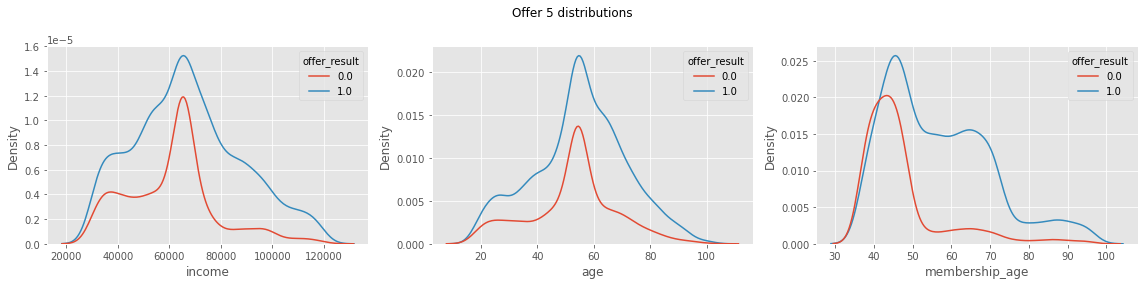

In [41]:
eda_offers(5, transactions)

Average Income $65440.30
Average Age 54.28 years
Average Membership_age 53.30 months


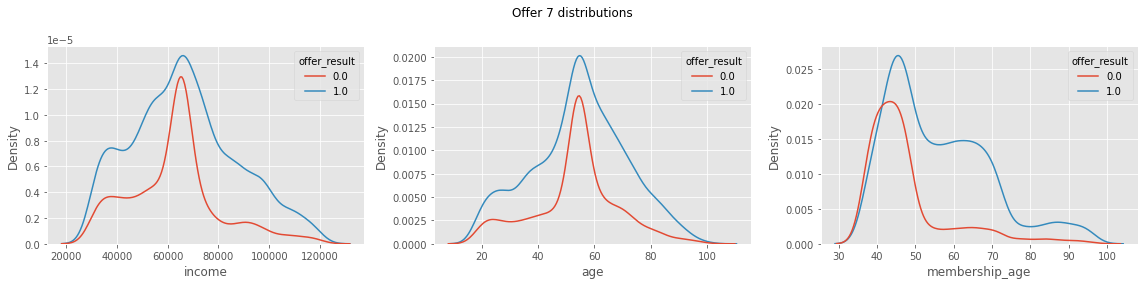

In [42]:
eda_offers(7, transactions)

Average Income $65453.93
Average Age 54.39 years
Average Membership_age 53.54 months


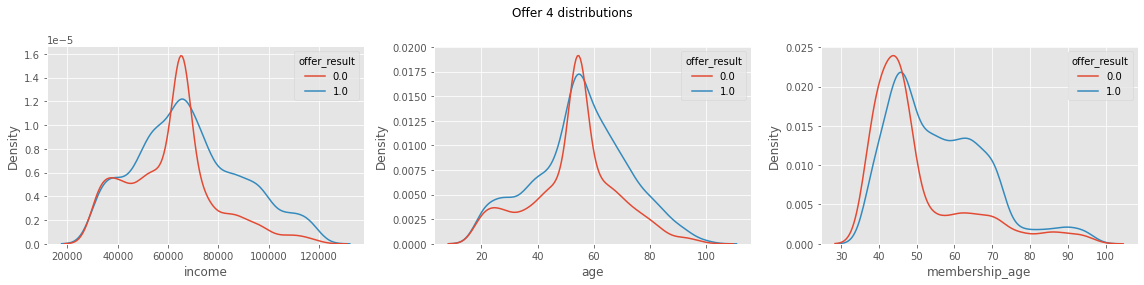

In [43]:
eda_offers(4, transactions)

We can see that our null values imputation changes the distribution on **income** and **age**, but for a moment let's work with the data in this way.

In [44]:
for var in ['reward', 'difficulty', 'duration']:
    result_agg = transactions.groupby(var).agg(pos_result = ('offer_result', 'sum'), total_result=('customer_id', 'count')).reset_index()
    result_agg['% Success'] = 100*result_agg['pos_result']/result_agg['total_result']
    print(result_agg[[var, '% Success']])
    print('-------------------------------------')

   reward  % Success
0       0   0.000000
1       2  54.275977
2       3  68.189723
3       5  40.182192
4      10  44.615869
-------------------------------------
   difficulty  % Success
0           0   0.000000
1           5  48.815091
2           7  68.189723
3          10  49.429327
4          20  23.093819
-------------------------------------
   duration  % Success
0         3   0.000000
1         4   0.000000
2         5  51.461245
3         7  47.653814
4        10  46.474107
-------------------------------------


In [45]:
transactions.head()

,customer_id,offer_id,offer_result,reward,channels,difficulty,duration,channel_web,channel_email,channel_mobile,...,offer_type_discount,offer_type_informational,age,income,gender_cat,gender_F,gender_M,gender_N,gender_O,membership_age
0,0009655768c64bdeb2e877511632db8f,1,0.0,2,"[web, email, mobile]",10,7,1,1,1,...,1,0,33.0,72000.0,M,0,1,0,0,51.812152
1,0009655768c64bdeb2e877511632db8f,2,0.0,0,"[web, email, mobile]",0,4,1,1,1,...,0,1,33.0,72000.0,M,0,1,0,0,51.812152
2,0009655768c64bdeb2e877511632db8f,3,0.0,0,"[email, mobile, social]",0,3,0,1,1,...,0,1,33.0,72000.0,M,0,1,0,0,51.812152
3,0009655768c64bdeb2e877511632db8f,4,1.0,5,"[web, email, mobile, social]",5,5,1,1,1,...,0,0,33.0,72000.0,M,0,1,0,0,51.812152
4,0009655768c64bdeb2e877511632db8f,5,1.0,2,"[web, email, mobile, social]",10,10,1,1,1,...,1,0,33.0,72000.0,M,0,1,0,0,51.812152


### Modelling (Customer Clustering)

First of all, before we going to a predictive aproach, we need to understand our customers, especially the clients who successfully convert to an offer. We need that to understand how this type of clients behave.

In this notebook, we gonna try to cluster all the clients that convert for an offer. We gonna use an model called [**K-Prototypes**](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.15.4028&rep=rep1&type=pdf) to do that.

The K-Prototypes is a model for Mix-Feature clustering.

In [46]:
clustering_transactions = transactions[transactions.offer_result == 1].copy()

In [47]:
clustering_transactions.describe()

,offer_id,offer_result,reward,difficulty,duration,channel_web,channel_email,channel_mobile,channel_social,offer_type_bogo,offer_type_discount,offer_type_informational,age,income,gender_F,gender_M,gender_N,gender_O,membership_age
count,24460.000000,24460.0,24460.000000,24460.000000,24460.000000,24460.000000,24460.0,24460.000000,24460.000000,24460.000000,24460.000000,24460.0,24460.000000,24460.000000,24460.000000,24460.000000,24460.000000,24460.000000,24460.000000
mean,6.218724,1.0,4.966067,8.813818,7.194399,0.883769,1.0,0.939820,0.738716,0.483524,0.516476,0.0,55.690119,68899.650037,0.449877,0.494767,0.039289,0.016067,56.024617
std,2.585469,0.0,3.002893,3.534601,1.787389,0.320508,0.0,0.237825,0.439343,0.499739,0.499739,0.0,16.374790,20775.991440,0.497492,0.499983,0.194285,0.125736,13.145732
min,1.000000,1.0,2.000000,5.000000,5.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.0,18.000000,30000.000000,0.000000,0.000000,0.000000,0.000000,36.666051
25%,5.000000,1.0,2.000000,5.000000,5.000000,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.0,46.000000,54000.000000,0.000000,0.000000,0.000000,0.000000,45.438305
50%,7.000000,1.0,5.000000,10.000000,7.000000,1.000000,1.0,1.000000,1.000000,0.000000,1.000000,0.0,55.000000,67000.000000,0.000000,0.000000,0.000000,0.000000,53.717735
75%,8.000000,1.0,5.000000,10.000000,7.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.0,67.000000,83000.000000,1.000000,1.000000,0.000000,0.000000,64.855541
max,10.000000,1.0,10.000000,20.000000,10.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,0.0,101.000000,120000.000000,1.000000,1.000000,1.000000,1.000000,96.560504


In [48]:
clustering_transactions['number_channels'] = clustering_transactions.channels.apply(lambda x: len(x))
clustering_transactions['channels'] = clustering_transactions.channels.apply(lambda x: '-'.join(x))

For now, let's remove all the dummy variables we have created before.

In [49]:
clustering_transactions = clustering_transactions.drop(columns=['customer_id', 'offer_result', 
                                      'channel_web', 'channel_email', 'channel_mobile', 'channel_social', 
                                      'offer_type_bogo', 'offer_type_discount', 'offer_type_informational', 
                                      'gender_F', 'gender_M', 'gender_N', 'gender_O'], axis= 1)

In [50]:
clustering_transactions.head()

,offer_id,reward,channels,difficulty,duration,offer_type_cat,age,income,gender_cat,membership_age,number_channels
3,4,5,web-email-mobile-social,5,5,bogo,33.0,72000.0,M,51.812152,4
4,5,2,web-email-mobile-social,10,10,discount,33.0,72000.0,M,51.812152,4
6,6,5,web-email,20,10,discount,40.0,57000.0,O,43.171318,2
7,7,3,web-email-mobile-social,7,7,discount,40.0,57000.0,O,43.171318,4
10,8,5,web-email-mobile,5,7,bogo,40.0,57000.0,O,43.171318,3


Reordering the columns: [Numerical, Categorical]

In [51]:
columns = ['number_channels', 'reward', 'membership_age', 'difficulty', 'age', 'income', 'duration','channels', 'offer_type_cat',  'gender_cat','offer_id']
clustering_transactions = clustering_transactions[columns]

In [52]:
clustering_transactions.head()

,number_channels,reward,membership_age,difficulty,age,income,duration,channels,offer_type_cat,gender_cat,offer_id
3,4,5,51.812152,5,33.0,72000.0,5,web-email-mobile-social,bogo,M,4
4,4,2,51.812152,10,33.0,72000.0,10,web-email-mobile-social,discount,M,5
6,2,5,43.171318,20,40.0,57000.0,10,web-email,discount,O,6
7,4,3,43.171318,7,40.0,57000.0,7,web-email-mobile-social,discount,O,7
10,3,5,43.171318,5,40.0,57000.0,7,web-email-mobile,bogo,O,8


In [53]:
clustering_transactions_original = clustering_transactions.copy()

Scaling the data.

In [54]:
scaler = StandardScaler()
scaling_features = ['number_channels', 'reward', 'membership_age', 'difficulty', 'age', 'income', 'duration']
clustering_transactions[scaling_features] = scaler.fit_transform(clustering_transactions[scaling_features])

In [74]:
clustering_transactions.shape

(24460, 11)

In [55]:
clustering_transactions.head()

,number_channels,reward,membership_age,difficulty,age,income,duration,channels,offer_type_cat,gender_cat,offer_id
3,0.723014,0.011300,-0.320450,-1.079018,-1.385702,0.149231,-1.227737,web-email-mobile-social,bogo,M,4
4,0.723014,-0.987757,-0.320450,0.335598,-1.385702,0.149231,1.569696,web-email-mobile-social,discount,M,5
6,-2.580728,0.011300,-0.977775,3.164830,-0.958207,-0.572771,1.569696,web-email,discount,O,6
7,0.723014,-0.654738,-0.977775,-0.513171,-0.958207,-0.572771,-0.108764,web-email-mobile-social,discount,O,7
10,-0.928857,0.011300,-0.977775,-1.079018,-0.958207,-0.572771,-0.108764,web-email-mobile,bogo,O,8


In [56]:
def train_cluster_model_kproto(df, n_cluster=10):
    cluster = []
    cost = []
    pbar = tqdm.tqdm(list(range(3, n_cluster+1, 1)))
    
    for K in pbar:
        pbar.set_description("Processing for %s clusters" % K)
        kproto = KPrototypes(n_clusters=K, init='Cao', n_jobs = -1, n_init = 8, random_state=9)
        clusters = kproto.fit_predict(df, categorical=[7, 8, 9, 10])
        cluster.append(K)
        cost.append(kproto.cost_)

    r = pd.DataFrame({"K": cluster, "Cost": cost})

    plt.plot(r['K'], r['Cost'], 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method using Distortion')
    plt.savefig('outputs/elbow_plot.png')
    plt.show()

Processing for 10 clusters: 100%|████████████████████████████████████████████████████████| 8/8 [10:57<00:00, 82.13s/it]


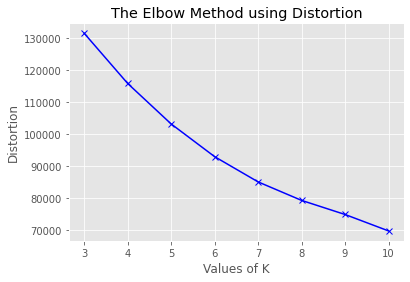

In [57]:
train_cluster_model_kproto(clustering_transactions, 10)

Analyzing the elbow plot, we don't have a lot of distortion among the clusters, so for a first analysis, let's choose 5 clusters.

In [58]:
kproto = KPrototypes(n_clusters=5, init='Cao', n_jobs = -1, n_init = 8, verbose=2, random_state=9)
clusters = kproto.fit_predict(clustering_transactions, categorical=[7, 8, 9, 10])

Best run was number 2


##### Saving the model artifacts

In [59]:
filename = 'outputs/kprototypes_model_v1.joblib'
joblib.dump(kproto, open(filename, 'wb'))

scaler_filename = 'outputs/scaler.joblib'
joblib.dump(scaler, scaler_filename) 

model_vars = ['number_channels', 'reward', 'membership_age', 'difficulty', 'age', 'income', 'duration','channels', 'offer_type_cat',  'gender_cat', 'offer_id']
model_vars_filename =  'outputs/model_variables.joblib'
joblib.dump(scaler, model_vars_filename) 

['outputs/model_variables.joblib']

#### Clusters Analysis

In [60]:
clustering_transactions_original['cluster'] = clusters

In [61]:
clustering_transactions_original.head()

,number_channels,reward,membership_age,difficulty,age,income,duration,channels,offer_type_cat,gender_cat,offer_id,cluster
3,4,5,51.812152,5,33.0,72000.0,5,web-email-mobile-social,bogo,M,4,4
4,4,2,51.812152,10,33.0,72000.0,10,web-email-mobile-social,discount,M,5,2
6,2,5,43.171318,20,40.0,57000.0,10,web-email,discount,O,6,0
7,4,3,43.171318,7,40.0,57000.0,7,web-email-mobile-social,discount,O,7,4
10,3,5,43.171318,5,40.0,57000.0,7,web-email-mobile,bogo,O,8,4


In [62]:
agg_table = clustering_transactions_original.groupby('cluster').agg(offers_completed = ('cluster', 'count')).reset_index()
agg_table['%'] = 100*agg_table['offers_completed']/agg_table['offers_completed'].sum()
agg_table

,cluster,offers_completed,%
0,0,1472,6.017989
1,1,5667,23.168438
2,2,4433,18.123467
3,3,6521,26.659853
4,4,6367,26.030253


In [63]:
numericals = ['reward', 'membership_age', 'difficulty', 'age', 'income', 'duration']
categoricals = ['channels', 'offer_type_cat', 'gender_cat', 'offer_id']

##### Exploring the numerical variables

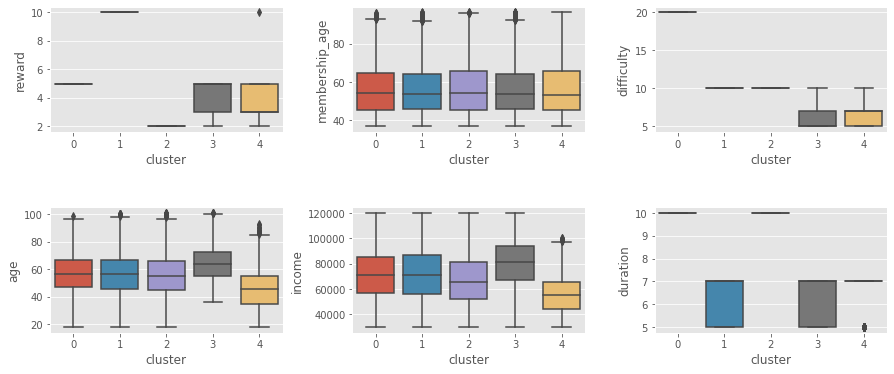

In [73]:
fig, axs = plt.subplots(2, 3, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .6, wspace=.3)
axs = axs.ravel()
for var, ax in zip(numericals, axs):
    sns.boxplot(x='cluster', y=var, data=clustering_transactions_original, ax=ax)
plt.savefig('outputs/cluster_num_vars.png')

We can se here that some of the variables don't tell much about the customer who convert. The only varriables that explains with a certain confidence are **age**, **reward** and **income**. 

Let's see how the categorical variables behave.

##### Exploring the categoricals variables

In [75]:
def cluster_categorical_analysis(cluster):
    fig, axs = plt.subplots(2,2, figsize=(10, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = 1, wspace=.1)
    axs = axs.ravel()
    cluster = cluster
    for var, ax in zip(categoricals, axs):
        df = clustering_transactions_original[clustering_transactions_original.cluster  == cluster][var].value_counts().reset_index()
        df['%'] = df[var]*100/df[var].sum()
        df.columns = [var, 'count', '%']
        df.plot(x = var, y = '%', kind='bar', ax=ax, rot=20, title='[Cluster {0}] Distribution for: {1}'.format(cluster, var))
    plt.savefig('outputs/cluster_cat_vars_cluster_{0}.png'.format(str(cluster)))

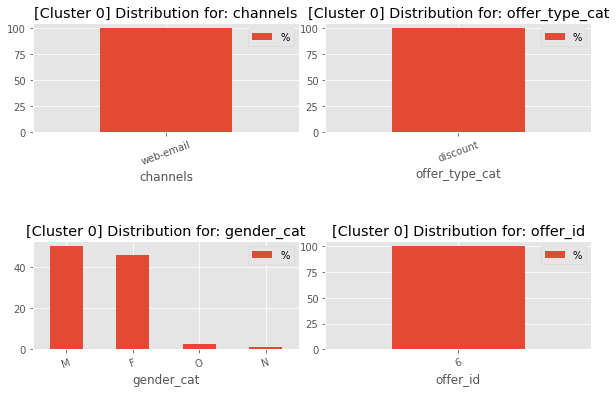

In [76]:
cluster_categorical_analysis(0)

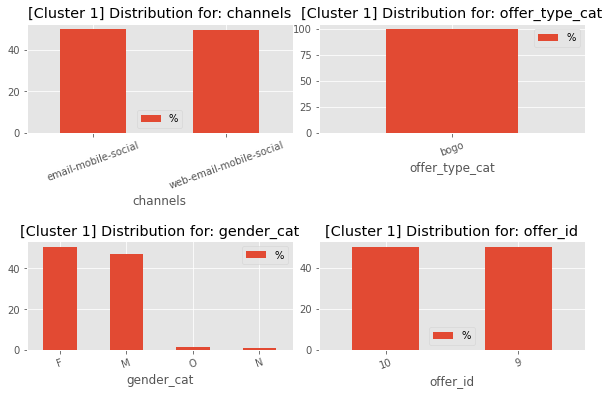

In [77]:
cluster_categorical_analysis(1)

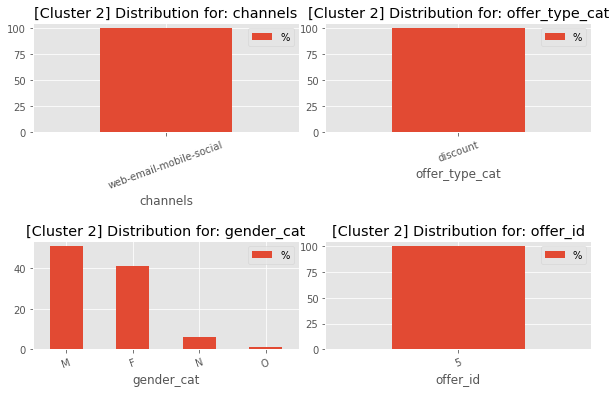

In [78]:
cluster_categorical_analysis(2)

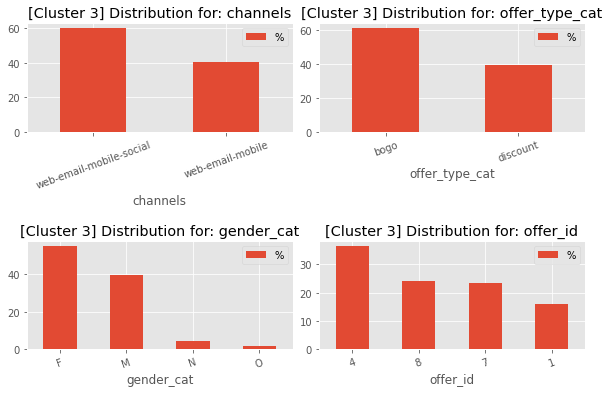

In [79]:
cluster_categorical_analysis(3)

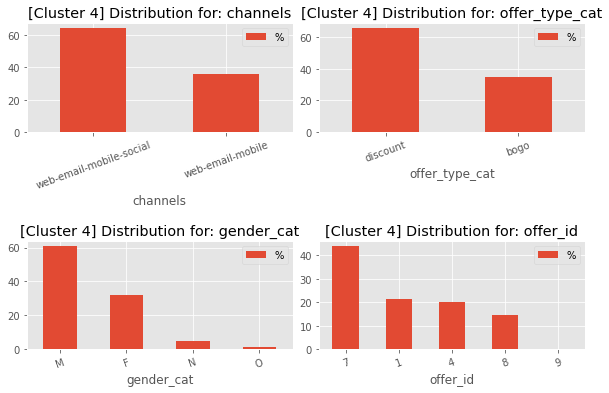

In [80]:
cluster_categorical_analysis(4)

##### Categorical variables distributions

In [87]:
def plot_clusters(var_name, df):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(15,4))
    df_aux = df.groupby(['cluster', var_name]).agg(count=(var_name,'count')).reset_index()
    df_aux2 = df_aux.groupby('cluster').agg(total=('count', 'sum'))
    df_aux3 = pd.merge(df_aux, df_aux2, on='cluster', how='inner')
    df_aux3['%'] = round(df_aux3['count']*100/df_aux3['total'], 2)
    sns.barplot(x='cluster', y='%', hue=var_name, data=df_aux3, ax=ax1)
    sns.barplot(x='cluster', y='count', hue=var_name, data=df_aux3, ax=ax2)
    plt.savefig('outputs/cluster_cat_distri_{0}.pdf'.format(var_name))
    plt.show()

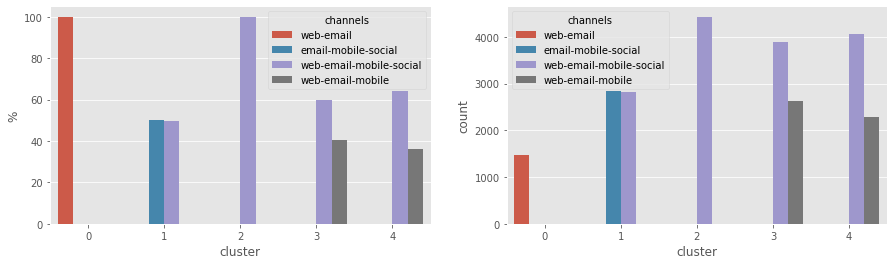

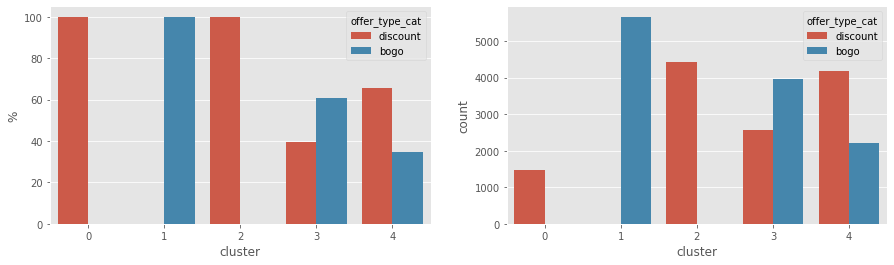

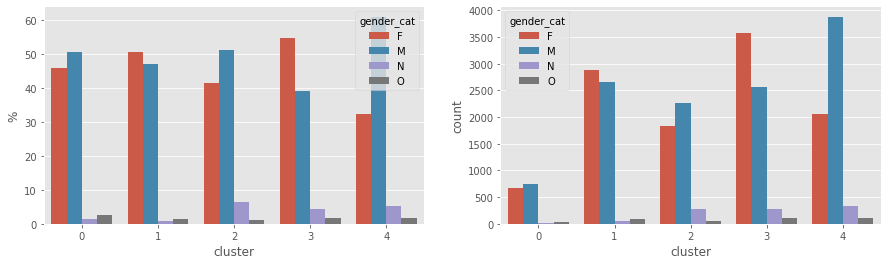

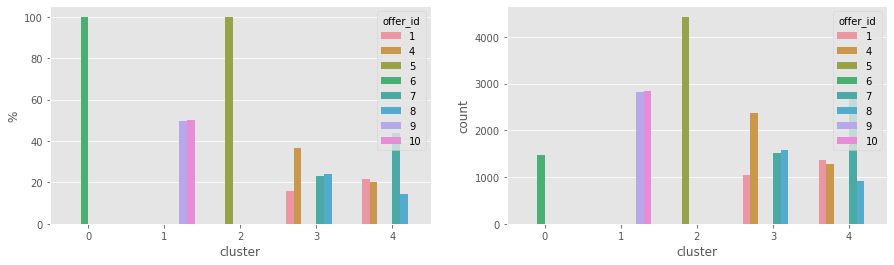

In [88]:
for i in categoricals:
    plot_clusters(i, clustering_transactions_original)

Analyzing each cluster individually, we can identify the cluster personas:

**Cluster 0 - 1472 (~6%) clients**:
   - Clients with **reward** equal to 5, **difficulty** equal to 20 and **duration** equal to 10;
   - All this clients convert from web and email;
   - The offer type they receive is **discount**;
   - And all of then convert from the  **offer number 6**.

**Cluster 1 - 5667 (~23.2%) clients**:
   - Clients with **reward** equal to 10, **difficulty** equal to 10 and **duration** falls between 5 and 7;
   - All the clients in this cluster convert from all channels;
   - They convert from **bogo** offers;
   - And all of then convert from the **offers number 9 and 10**.

**Cluster 2 - 4433 (~18.1%) clients**:
   - Clients with **reward** equal to 2, **difficulty** equal to 10 and **duration** equals to 10;
   - All the clients in this cluster convert from all channels;
   - They convert from **discount** offers;
   - And all of then convert from the  **offer number 5**.

**Cluster 3 - 6521 (~26.6%) clients**:
   - Clients with **reward** that falls between to 3 and 5, **difficulty** falls between to 5 and 7 and **duration** falls between to 5 and 7;
   - They are on average the oldest clients and with the highest average income.
   - All the clients in this cluster convert from all channels;
   - They convert from **discount** (40%) and **bogo** (60%) offers;
   - About 60% of the clients are males;
   - They convert from multiple offers (1, 4, 7 e 8).

**Cluster 4 - 6367 (~26%) clients**:
   - Clients with **reward** that falls between to 3 and 5, **difficulty** falls between to 5 and 7 and **duration** equals to 7;
   - They are on average the youngest clients and with the lowest average income.
   - All the clients in this cluster convert from all channels;
   - They convert from **discount** (60%) and **bogo** (40%) offers;
   - About 60% of the clients are females;
   - They convert from multiple offers (1, 4, 7, 8).

### Observations and future work

From the clusters, we observe that they separate our clients to a few characteristics that we can work with the marketing team to boost sales.

Other important observation we can make is that not all the offers we send have an good impact on the convertion. The offer that convert very few people have to be rethought.

Other way to observe the behavior of the clients os to cluster all the clients, the ones who convert and the ones who don't. this will gave us more information about all the clients we have and investigate some bias in our first clusters.

If some of our cluster successfully change of convertions (A/B testing), we can go further and use some predictive machine learning model to infer what is the probability of a customer convert to a offer (y cluster). We can use a [**lift chart**](https://www.ibm.com/docs/en/db2/10.5?topic=SSEPGG_10.5.0/com.ibm.im.visual.doc/c_lift_chart_class.html) to verify the performance of our model and work together with the CRM teams.